In [4]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

# outer fns
    function chop_f(f)
        Nx, _ = size(f)
        g = circshift(f, (Nx÷2,0))
        rho = sum(g;dims=2)[:,1]    
        I = argmin(rho):1:argmax(g[:,1]+g[:,2])
        return [g[i,j] for i in I, j in 1:3]
    end

    function resize_f(f, LLx, NNx)
        Nx, _ = size(f)
        Δx = 1/Nx
        ΔΔx = 1/NNx
        function fx(x,k)
            i::Int64 = x÷Δx
            j = i+1
            if i == 0
                i = 1
            end
            if j == Nx+1
                j = Nx
            end
            return ( (Δx*(i+1)- x)*f[i,k] + (x-Δx*i)*f[j,k] )/(Δx)
        end
        g = [fx(x,k) for x in ΔΔx:ΔΔx:1, k in 1:3]

        Δx = LLx/NNx
        Lx = LLx
        Nx = NNx
        @pack! param = Nx, Lx, Δx
        return param, circshift(g,(NNx÷2,0))
    end

    function rho_out_eq(ρ,ρa,c,i; p = p)
        DT, v0, DR, _, Nx, _, ϕa, ϕaL, ϕaR, ϕL, ϕR = p
        Δx = 1/Nx
        Lx = 1
        iplus  = i+1
        ρ1 = ρ[i] 
        ρ2 = ρ[i+1]
        ρ3 = 2*(ρ1*ρ2)/(ρ1+ρ2)
        ρa1 = ρa[i] 
        ρa2 = ρa[i+1]
        ρa3 = 2*(ρa1*ρa2)/(ρa1+ρa2)
        return -c*(ρ2+ρ1)/2 + (DT/Δx)*(ρ2-ρ1) + (v0^2/DR/Δx/2)*(ds(ρ3)*(1-ρ3)*(ρa2-ρa1) + ρa3*dsp(ρ3)*(1-ρ3)*(ρ2-ρ1) )
    end

    function act_out_eq(ρ,ρa,c,i; p = p)
        DT, v0, DR, _, Nx, _, ϕa, ϕaL, ϕaR, ϕL, ϕR = p
        Δx = 1/Nx
        Lx = 1
        iplus  = i +1
        ρ1 = ρ[i] 
        ρ2 = ρ[i+1]
        ρ3 = 2*(ρ1*ρ2)/(ρ1+ρ2)
        ρa1 = ρa[i] 
        ρa2 = ρa[i+1]
        ρa3 = 2*(ρa1*ρa2)/(ρa1+ρa2)
        return -c*(ρa2+ρa1)/2 + (DT/Δx)*( ds(ρ3)*(ρa2-ρa1) + ρa3*DD(ρ3)*(ρ2-ρ1) ) + (v0^2/DR/Δx/2)*( ds(ρ3)*( ρa3*ss(ρ3)+ds(ρ3) )*(ρa2-ρa1) + ρa3*dsp(ρ3)*( ρa3*ss(ρ3)+ds(ρ3) )*(ρ2-ρ1) )
    end

    function ff_out(F,u,p)
            DT, v0, DR, _, Nx, _, ϕa, ϕaL, ϕaR, ϕL, ϕR = p
            global ρ,ρa,m
            local c
            ρ  = u[(0*Nx+1):1:(1*Nx)]
            ρa = u[(1*Nx+1):1:(2*Nx)]
            c  = u[end]

            for i in 2:(Nx-1)
                F[i-1]        = rho_out_eq(ρ,ρa,c,i; p = p) - rho_out_eq(ρ,ρa,c,1; p = p)
                F[Nx-3+i]   = act_out_eq(ρ,ρa,c,i; p = p) - act_out_eq(ρ,ρa,c,1; p = p)
            end

            F[2*Nx-3] = ρa[1] - ϕaL
            F[2*Nx-2] = ρa[end] - ϕaR
            F[2*Nx-1] = ρ[1] - ϕL
            F[2*Nx]   = ρ[end] - ϕR
            F[2*Nx+1] = sum(ρa)/Nx - ϕa
    end

    function get_out_f(u,param)
        @unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
        Nx = (length(u)-1)÷2
        ρ  = u[(0*Nx+1):1:(1*Nx)]
        ρa = u[(1*Nx+1):1:(2*Nx)]
        # m  = u[(2*Nx+1):1:(3*Nx)]
        # c  = u[end]
        m = -(v0/2/DR/Δx)*( ρa.*ds.(ρ) - circshift(ρa.*ds.(ρ), 1))
        m[1] = m[2]
        f = zeros(Nx,3)
        f[:,2] = ρa/2 + m/2
        f[:,1] = ρa/2 - m/2
        f[:,3] = ρ - ρa
        return circshift(f,(Nx÷2,0))
    end

    function get_out_u(f,c,Lx; shift = true)
        # flatten initial guess
        Nx, _ = size(f)
        if shift
            f = circshift(f,(Nx÷2,0))
        end
        ρ = sum(f;dims = 2)
        ρa = f[:,2] + f[:,1]
        C = [c*Lx]
        return vcat(ρ,ρa,C)
    end

    d3(x) = round(x;digits = 3)

    function outer_save_name(param,γ)
        @unpack DT, v0, DR, Nx, Lx, name = param
        return "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/outer_sol/$(name)/[DT,v0,DR,Nx,ϕa,γ]=$([DT,v0,DR,Nx,ϕa,d3(γ)]).jld2"
    end

    function get_BC(γ,Pe;initial_Δ = 1e-5, max_iter = 20, tol = 1e-8 )
        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol)
        if find_sol 
            ϕL, ϕR  = lower_limits[1], upper_limits[1]
            ϕaL, ϕaR = 1-γ*(1-ϕL), 1-γ*(1-ϕR)
            return ϕaL, ϕaR, ϕL, ϕR
        else
            print("no solution: output γ_max")
            ϕL = ϕR = find_rho_limit(;Pe = Pe, initial_Δ = initial_Δ, γ_max = 100.)
            ϕaL, ϕaR = 1-γ*(1-ϕL), 1-γ*(1-ϕR)
            return ϕaL, ϕaR, ϕL, ϕR
        end
    end

    function initial_guess(ps)
        ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR) = ps
        xs = collect(0:(1/(Nx-1)):1)
        ρ =   xs*(ϕR - ϕL) .+ ϕL
        ρa =  xs*(ϕaR-ϕaL) .+ ϕaL
        C = [1.5]
        return vcat(ρ,ρa,C)
    end

    function get_outer_param(Lx,Nx,ϕa,v0)
        param = get_stretch_param(Lx)
        name = "outer_sol"
        Δx = Lx/Nx
        @pack! param = Lx,Nx,ϕa,v0,name,Δx
        return param
    end

    function save_waves(wave_map)
        filename = "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/wave_map.jld2"
        data        = Dict("wave_map" => wave_map)
        wsave(filename,data)
    end

    function load_waves(wave_map)
        filename = "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/wave_map.jld2"
        data = load(filename)
        @unpack wave_map = data
        return wave_map
    end

    function load_out(ϕa,γ,v0; Lx = 100.0,Nx = 256)
        param = get_outer_param(Lx,Nx,ϕa,v0)
        filename = outer_save_name(param,γ)
        data = load(filename)
        @unpack f, c = data
        u = get_out_u(f,c,Lx)
        return f, u, c
    end

    using NonlinearSolve, DifferentialEquations
    function solve_out(ϕa,γ,v0,u0; Lx = 100.0, Nx = 256, initial_Δ = 1e-7, max_iter = 20, tol = 1e-8)
        param_out = get_outer_param(Lx,Nx,ϕa,v0)
        @unpack DT, v0, DR, Δx, Nx, Lx = param_out
        ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0;initial_Δ = initial_Δ, max_iter = max_iter, tol = tol) # tehcnically should be Pe 
        ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
        # Set problem
        prob = NonlinearProblem(ff_out,u0, ps; abstol = 1e-8, reltol =  1e-8);
        sol  = solve(prob)
        #
        # Save
            u = sol.u
            f = get_out_f(u,param)
            c = u[end]/Lx
            filename    = outer_save_name(param, γ)
            data        = Dict("f" => f, "c" => c)
            safesave(filename,data)
        #
        return f, u, c
    end
#


v3.0


solve_out (generic function with 1 method)

In [83]:
# Load initial wave
Lx = 100.0
Nx = 3200
param = get_dense_param(Lx,Lx/Nx)
    filename = steady_save_name(param)
    data = load(filename)
    @unpack f, c = data
    t = 0.0;
    LLx = param["Lx"]
#
    @unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp)
    u0 = get_u(f,c);
    F = zeros(3*Nx+1);
    ff(F,u0,ps);
    maximum(abs.(F))

1.3676347554447688e-9

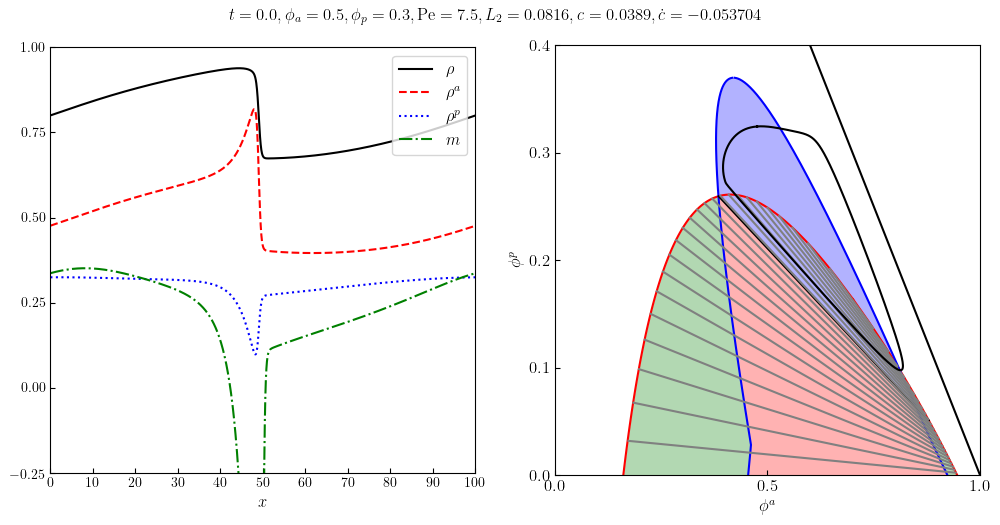

In [21]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f)

In [84]:
# Set gamma
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    Nx, _ = size(f)
    phi = sum(f;dims = 2)[Nx÷2,1]
    phia = f[Nx÷2,1] + f[Nx÷2,2]
    γ = round((1-phia)/(1-phi);digits =2)
#

1.83

In [85]:
# Get inital guess
    Nx = 1024
    f_chop = chop_f(f)
    param, f0 = resize_f(f_chop, Lx, Nx)
    u0 = get_out_u(f0,c; shift = true);
# Set Vars
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
#   

(1.0, 7.5, 1.0, 0.09765625, 1024, 100.0, 0.5, 0.3, 0.42544118105859985, 0.8650861497866713, 0.6860334322724589, 0.9262765845828805)

In [86]:
# Check max(F0)
F = zeros(2*Nx+1)
ff_out(F,u0,ps)
maximum(abs.(F))

0.08282777680077325

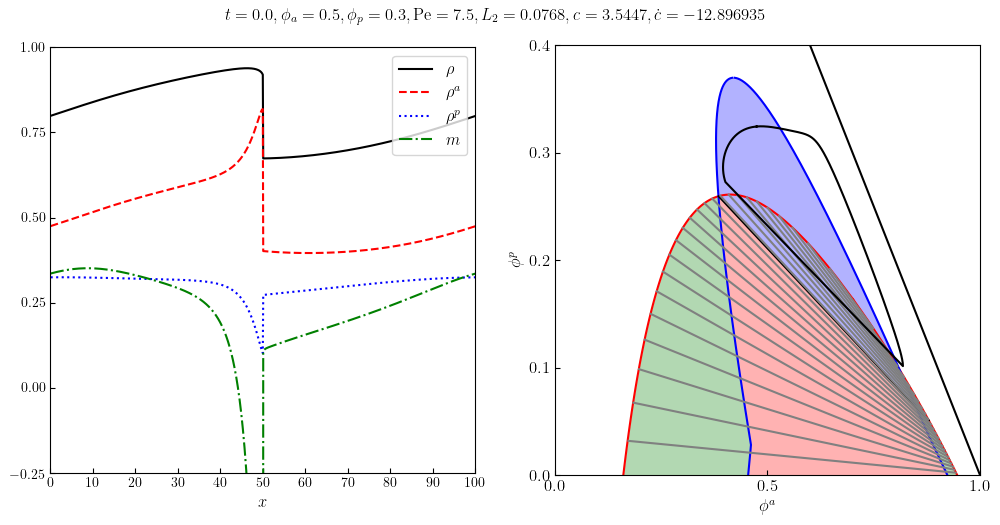

In [87]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f0)

In [88]:
# Set problem
    using NonlinearSolve, DifferentialEquations
    prob = NonlinearProblem(ff_out,u0, ps; abstol = 1e-8, reltol =  1e-8);
    sol  = solve(prob)
#
# Save
    u = sol.u
    f = get_out_f(u,param)
    c = u[end]/Lx
    filename    = outer_save_name(param, γ)
    data        = Dict("f" => f, "c" => c)
    safesave(filename,data)
#
# Check F(u)
    F = zeros(2*Nx+1)
    ff_out(F,u,ps)
    maximum(abs.(F))
#

3.3162338097803e-8

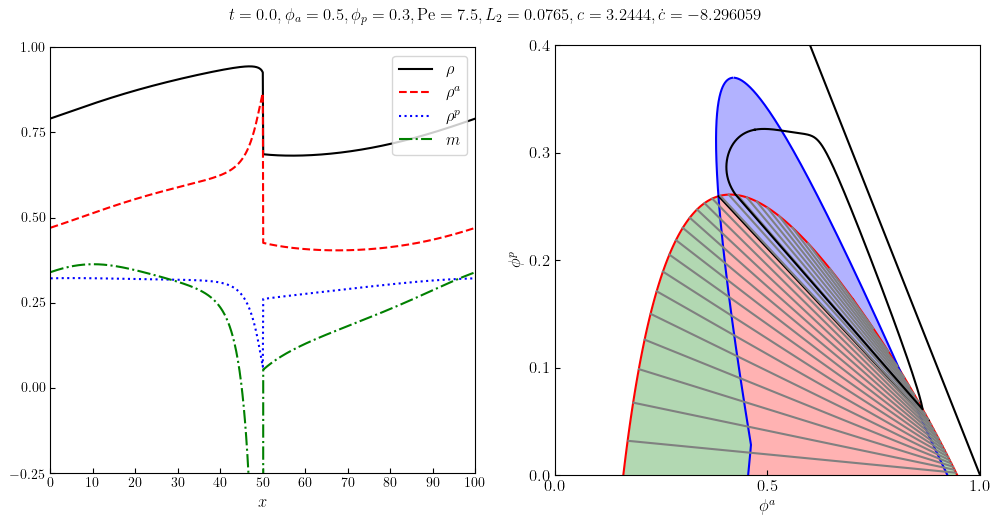

In [89]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f)

In [38]:
Lx = 100.0
Nx = 256
ϕa = 0.5
v0 = 7.5
param_out = get_outer_param(Lx,Nx,ϕa,v0)
@unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
γ_max = find_gamma_limit(;Pe = v0, initial_Δ = 1e-4, γ_max = 100.)

2.210468050190708

In [90]:
# Load initial wave
Lx = 100.0
Nx = 1024
ϕa = 0.5
v0 = 7.5
γ = 1.83
param_out = get_outer_param(Lx,Nx,ϕa,v0)
    filename = outer_save_name(param,γ)
    data = load(filename)
    @unpack f, c = data
    t = 0.0;
#
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
    u = get_out_u(f,c);
    F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F))

3.3162338097803e-8

In [91]:
wave_map = Dict{String,Float64}()
d2(x) = round(x; digits=2)
Lx, Nx, ϕa, v0, γ = 100.0, 1024, 0.5, 7.5, 1.83
f, u, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
ϕp =  sum(f)/Nx-sum(f[:,1:2])/Nx
wave_map["$(ϕa),$(d2(γ))"] = ϕp

for γ in 1.84:0.01:(γ_max-0.01)
    global f, u, c, ϕa, v0, Lx, Nx, u0, wave_map
    local ϕp
    u0 = copy(u)
    f, u, c = solve_out(ϕa,γ,v0,u0; Lx = Lx, Nx = Nx)
    ϕp =  sum(f)/Nx-sum(f[:,1:2])/Nx
    wave_map["$(ϕa),$(d2(γ))"] = ϕp 
end
print(wave_map)

Dict("0.5,2.2" => 0.3115533064552126, "0.5,2.06" => 0.30826620981316877, "0.5,1.98" => 0.30606833750906126, "0.5,2.04" => 0.30776103875158944, "0.5,1.86" => 0.3011832800204459, "0.5,2.18" => 0.31107388939652414, "0.5,2.05" => 0.30801637875551613, "0.5,2.14" => 0.3101482357369276, "0.5,2.0" => 0.306668865499206, "0.5,2.09" => 0.30898980472620874, "0.5,2.03" => 0.3074994282752379, "0.5,2.19" => 0.3113105129342957, "0.5,2.08" => 0.3087522367451023, "0.5,2.17" => 0.3108402725134045, "0.5,1.95" => 0.3050782615513933, "0.5,1.83" => 0.29946018032589106, "0.5,1.85" => 0.30063729253000726, "0.5,2.07" => 0.3085112623378311, "0.5,2.15" => 0.31037806788616673, "0.5,1.9" => 0.30311817814490316, "0.5,2.16" => 0.3106085580456467, "0.5,1.91" => 0.30354664278801224, "0.5,1.84" => 0.30006344449762856, "0.5,1.96" => 0.3054215496347642, "0.5,1.97" => 0.30575122574018043, "0.5,1.93" => 0.30434646096896034, "0.5,1.88" => 0.30219767283935073, "0.5,2.1" => 0.3092246104865085, "0.5,1.92" => 0.303955653429991, 

In [181]:
Lx, Nx, ϕa, v0, γ = 100.0, 1024, 0.5, 7.5, 1.45
f, u, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx
# for γ in 1.44:(-0.01):(1.01)
#     global f, u, c, ϕa, v0, Lx, Nx, u0, wave_map
#     local ϕp
#     u0 = copy(u)
#     f, u, c = solve_out(ϕa,γ,v0,u0; Lx = Lx, Nx = Nx)
#     ϕp =  sum(f)/Nx-sum(f[:,1:2])/Nx
#     wave_map["$(ϕa),$(d2(γ))"] = ϕp 
# end
# print(wave_map)

(0.6257160926179874, 0.22089535360610524)

In [46]:
# load prev
Lx, Nx, ϕa, v0, γ = 100.0, 1024, 0.5, 7.5, 2.21 #1.449#1.4492578
f, u, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
# set new ps
Lx, Nx, ϕa, v0, γ = 100.0, 1024, 0.5, 7.5, 2.21
param = get_outer_param(Lx,Nx,ϕa,v0)
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0; initial_Δ = 1e-7, max_iter = 20, tol = 1e-8) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F)), maximum(f[:,2]-f[:,1]), minimum(f[:,2]-f[:,1]), c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx

([0.2264758092609631 0.2293039105354419 0.33461286557142417; 0.2266061968624064 0.22943873297532758 0.334688439074932; … ; 0.22621647781794013 0.22903567086772797 0.33446043953674154; 0.2263459023246833 0.22916955586217755 0.334536865471109], [0.8649239; 0.8299553609019925; … ; 0.7014818190000001; 1.6445861181686556;;], 0.016445861181686557)

In [37]:
f, u, c = solve_out(ϕa,γ,v0,u; Lx = Lx, Nx = Nx, initial_Δ = 1e-7)
c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx

no solution: output γ_max

(1.6445861181686556, 0.3118649164263818)

In [40]:
get_BC(2.21,v0; initial_Δ = 1e-6, max_iter = 20, tol = 1e-8)

no solution: output γ_max

(0.7014842499999998, 0.7014842499999998, 0.8649249999999999, 0.8649249999999999)

In [41]:
get_BC(2.21,v0; initial_Δ = 1e-7, max_iter = 20, tol = 1e-8)

no solution: output γ_max

(0.701481819, 0.701481819, 0.8649239, 0.8649239)

In [98]:
min_key = argmin(wave_map)
max_key = argmax(wave_map)
print("$(min_key): $(wave_map[min_key]),  $(max_key): $(wave_map[max_key])")

0.5,1.45: 0.2220218190906773,  0.5,2.2: 0.3115533064552126

In [118]:
wave_map = load_waves(param);

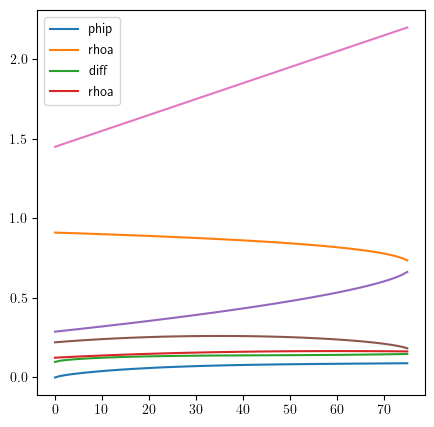

In [136]:
fig, ax = subplots(1,1,figsize=(5,5))
y1 = collect(1.45:0.01:2.2)
y2 = collect(1.45:0.01:2.2)
y3 = collect(1.45:0.01:2.2)
y4 = collect(1.45:0.01:2.2)
y5 = collect(1.45:0.01:2.2)
y6 = collect(1.45:0.01:2.2)
d2(x) = round(x;digits = 2)
for (i,γ) in enumerate(collect(1.45:0.01:2.2))
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0; initial_Δ = 1e-6, max_iter = 20, tol = 1e-8) # tehcnically should be Pe 
    y1[i] = wave_map["$(ϕa),$(d2(γ))"]
    y2[i] = ϕaR
    y4[i] = ϕaL
    y5[i] = ϕR-ϕaR
    y5[i] = ϕL-ϕaL
    y3[i] = (ϕR-ϕaR + ϕL-ϕaL)/2
end
ax.plot(y1.-y1[1]; label="phip")
ax.plot(y2; label="rhoa")
ax.plot(y1-y3; label="diff")
ax.plot(y3; label="rhoa")
ax.plot(y4)
ax.plot(y5)
ax.plot(y6)
ax.legend()
display(fig)

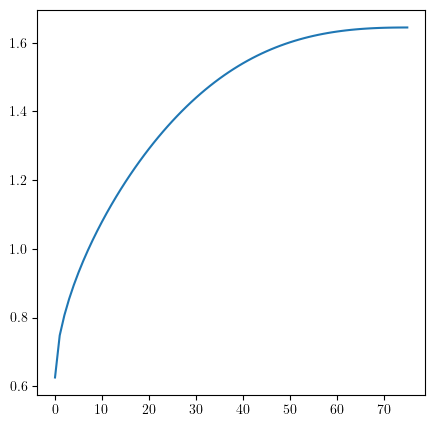

In [178]:
fig, ax = subplots(1,1,figsize=(5,5))
y = collect(1.45:0.01:2.2)
Lx, Nx, ϕa, v0 = 100.0, 1024, 0.5, 7.5
for (i,γ) in enumerate(collect(1.45:0.01:2.2))
    local c
    _, _, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
    y[i] = c*Lx
end
ax.plot(y)
display(fig)

In [120]:
# Load initial wave
Lx, Nx, ϕa, v0, γ = 100.0, 1024, 0.5, 7.5, 1.45
param = get_outer_param(Lx,Nx,ϕa,v0)
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
    
f, u, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
    F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F))

5.527899249457846e-10

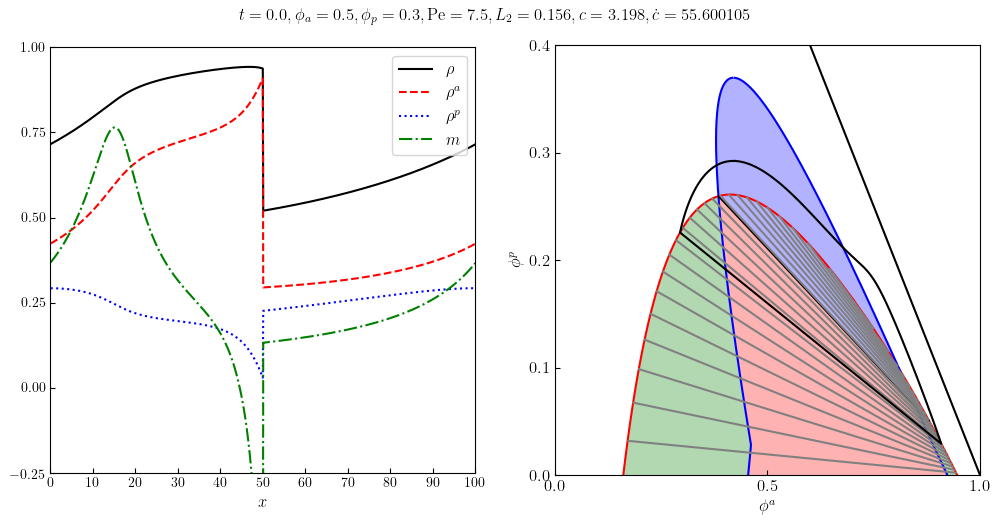

In [226]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f)

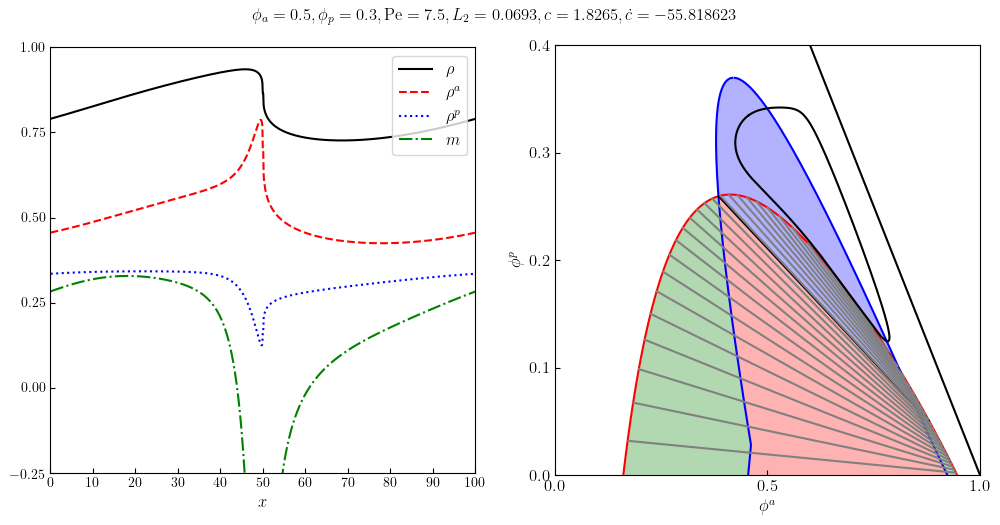

In [110]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f)

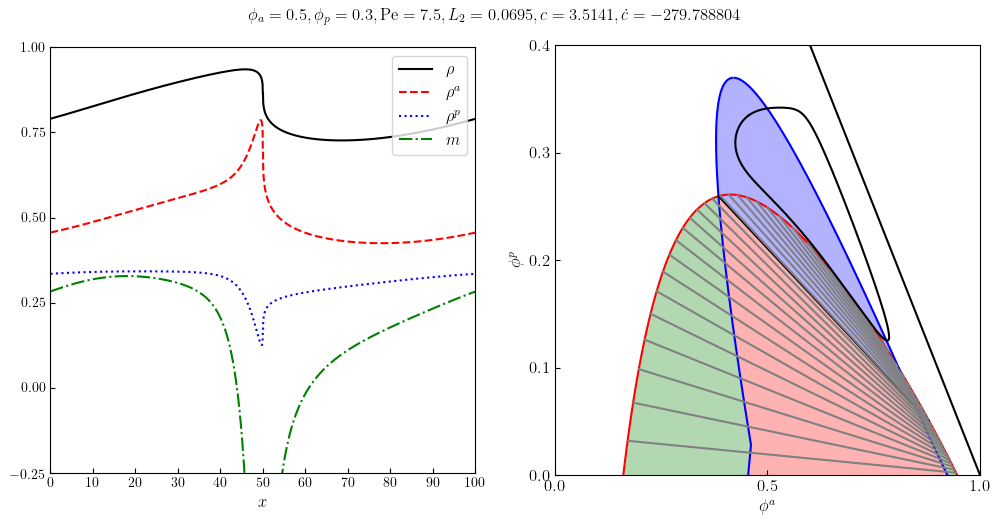

In [112]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f)

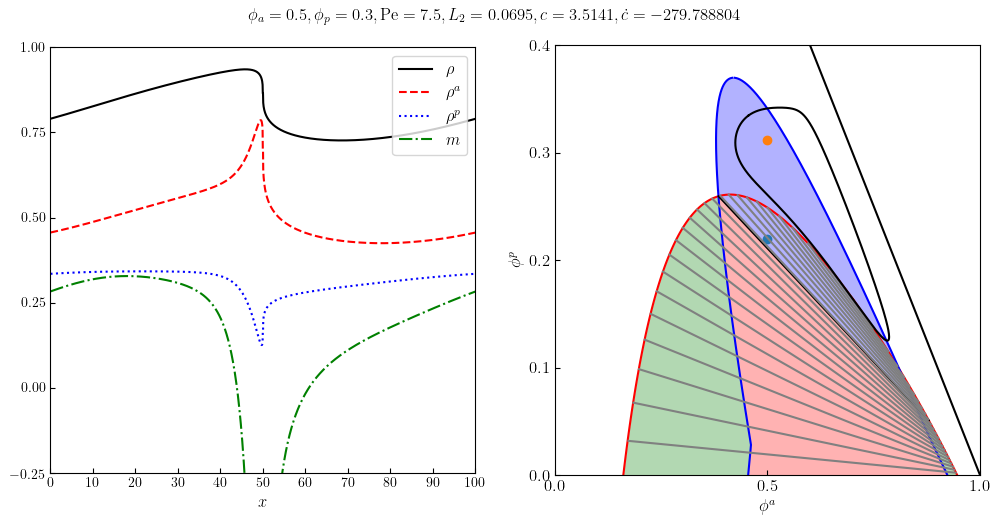

In [113]:
axs[2].scatter(0.5,0.21949638479492728)
# axs[2].scatter(0.5,y[74])
# axs[2].scatter(0.5,y[75])
axs[2].scatter(0.5,sum(f)/Nx-sum(f[:,1:2])/Nx)
display(fig)

In [111]:
# load prev
Lx, Nx, ϕa, v0, γ = 100.0, 2048, 0.5, 7.5, 2.21  #1.449#1.4492578
f, u, c = load_out(ϕa,γ,v0; Lx = Lx,Nx = Nx)
param = get_outer_param(Lx,Nx,ϕa,v0)
    @unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0; initial_Δ = 1e-7, max_iter = 20, tol = 1e-8) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F)), maximum(f[:,2]-f[:,1]), minimum(f[:,2]-f[:,1]), c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx, u[1]-ϕL, ϕL, Nx

no solution: output γ_max

(4.674038933671909e-13, 0.0032785780303152823, -0.5688419397434463, 1.6431745345356563, 0.3118620244800066, 0.0, 0.8649239, 2048)

In [100]:
u, param  = extend_sol(u, param)
f = get_out_f(u,param)
@unpack Lx, Nx = param
Lx, Nx
@unpack DT, v0, DR, Δx, Nx, Lx = param
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0; initial_Δ = 1e-7, max_iter = 20, tol = 1e-8) # tehcnically should be Pe 
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕaL, ϕaR, ϕL, ϕR)
F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F)), maximum(f[:,2]-f[:,1]), minimum(f[:,2]-f[:,1]), c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx, u[1]-ϕL, ϕL
# f, u, c = solve_out(ϕa,γ,v0,u; Lx = Lx, Nx = Nx, initial_Δ = 1e-7)

(0.2136157911443226, 0.003374442178162851, -0.1027222074268519, 1.6400547204456075, 0.3092548878521234, 0.0, 0.7929540136548006)

In [102]:
f, u, c = solve_out(ϕa,γ,v0,u; Lx = Lx, Nx = Nx, initial_Δ = 1e-7)

([0.22741639283755752 0.23035895057670716 0.3313052064974705; 0.22748671808710844 0.23043153764103033 0.3313406937935666; … ; 0.22727610947456625 0.23021413269607185 0.33123388462242215; 0.22734618988191857 0.2302864821694941 0.3312696034136411], [0.7929540136548006, 0.7915097553496524, 0.7901452661435729, 0.7888509515025552, 0.7876189609272141, 0.7864427770055836, 0.7853169207890186, 0.7842367356778445, 0.783198225711095, 0.782197932433246  …  0.8096745890017228, 0.8106543841168342, 0.8113659786552486, 0.8117425466175006, 0.8116894790322299, 0.8110643406017937, 0.8096330191337943, 0.806954360784079, 0.8019614178337879, 1.6388376093793362], 0.01638837609379336)

In [104]:
F = zeros(2*Nx+1);
    ff_out(F,u,ps);
    maximum(abs.(F)), maximum(f[:,2]-f[:,1]), minimum(f[:,2]-f[:,1]), c*Lx, sum(f)/Nx-sum(f[:,1:2])/Nx, u[1]-ϕL, ϕL, Nx


(6.210143510543276e-12, 0.003370567421139392, -0.1169708773942284, 1.6388376093793362, 0.3092586028370309, 0.0, 0.7929540136548006, 2048)

In [105]:
for γ in 2.11:(0.01):(2.21)
    global f, u, c, ϕa, v0, Lx, Nx
    local ϕp, u0
    u0 = copy(u)
    f, u, c = solve_out(ϕa,γ,v0,u0; Lx = Lx, Nx = Nx, initial_Δ = 1e-7) 
end

no solution: output γ_max

In [ ]:
x = collect(1:10)
y = (x + circshift(x,1))/2
y[1] = (x[1]+y[2])/2
y 

In [85]:
function extend_sol(u, param)
    @unpack Nx, Lx = param
    g = zeros(4*Nx+1)
    g[end] = u[end]
    g[2:2:(4*Nx)] = u[1:(2*Nx)]
    g[1:2:(2*Nx-1)] = (u[1:Nx] + circshift(u[1:Nx],1))/2
    g[1] = u[1]
    g[(2*Nx+1):2:(4*Nx-1)] = (u[(Nx+1):1:(2*Nx)] + circshift(u[(Nx+1):1:(2*Nx)],1))/2
    g[2*Nx+1] = u[Nx+1]
    Nx = 2*Nx
    Δx = Lx/Nx
    @pack! param = Nx, Δx
    return g, param
end

extend_sol (generic function with 1 method)

In [81]:
u2

4097-element Vector{Float64}:
 0.7922508395324297
 0.7929540136548006
 0.7915476654100588
 0.7901413171653171
 0.7888765928693552
 0.7876118685733933
 0.7864595482095932
 0.7853072278457931
 0.7842467734592141
 0.7831863190726351
 ⋮
 0.8105711969221547
 0.8114148924888042
 0.8115717938424454
 0.8117286951960867
 0.8106909094672106
 0.8096531237383345
 0.8058072707860613
 0.8019614178337879
 1.6400547204456075

In [42]:
sum(f[:,1:2])/Nx

0.5000000696784075

In [65]:
f, u, c = solve_out(ϕa,γ,v0,u; Lx = Lx, Nx = Nx, initial_Δ = 1e-7)

no solution: output γ_max

InterruptException: InterruptException: